# OTUS Paper Plots | $p p > Z > e^+ e^-$

This notebook creates the plots which are found in the paper: https://arxiv.org/abs/2101.08944. It also performs the statistical tests which are included in the supplementary material.

# Load Required Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.cm as cm
from scipy import stats

# Add utilityFunctions/ to easily use utility .py files
import sys
sys.path.append("../utilityFunctions")

# Meta Parameters

In [2]:
save_figs = True  # Global switch to turn on saving figures to files
N_slices  = 1000  # Global number of slices to calculate SW distance with

data_directory    = '../data/'
results_dataPath  = '../experiments/ppzee/otus_results-dataset=ppzee_test.npz'
dataset_name      = 'ppzee'
img_dir           = dataset_name+'Images/'

np.random.seed(4) # Set numpy random seed

# Get Truth Datasets and Model Results

The data was split into training, validation, and two testing sets. We load only the testing datasets here. We also load in the model results calculated on one of the testing datasets.  

Note that we have two separate testing sets to ensure the independence of samples when performing statistical tests.

Specifically, we have 4 initial datasets: x_test1, z_test1, x_test2, and z_test2.

Test set 1 has been used to obtain network results. These results will be compared to the independent test set 2.

For testing the encoder's performance we will use the following convention:
- z_pred_te1 = E(x_test1, $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z}$.

For testing the decoder's performance we will use the following convention:
- x_pred_truth_te1 = D(z_test1, $\epsilon$)

In plots this will be denoted as $z \rightarrow \tilde{x}'$.

For testing the overall performance of the full encoder-decoder chain we will use the following convention:
- x_pred_te1 = D(E(x_test1, $\epsilon$), $\epsilon$)

In plots this will be denoted as $x \rightarrow \tilde{z} \rightarrow \tilde{x}$.

Note that $\epsilon$ denotes the random noise input of the networks. Note that all $\epsilon$ are different random samples. This happens internally and thus won't be shown in what follows.

## Load in Truth Data (Testing Dataset)

In [3]:
from func_utils import get_dataset, standardize

#-- Load Testing Truth Data --#
truthDataset = get_dataset(dataset_name+'_test', data_dir=data_directory)
zData, xData = truthDataset['z_data'], truthDataset['x_data']

#-- Remove MET from xData --#
MET = False
if MET == False:
    xData = xData[:, :-4]
    
#-- Split data into the two testing sets --#
f_test1 = int(0.5*zData.shape[0])

x_test1  = xData[0:f_test1]
z_test1  = zData[0:f_test1]

x_test2  = xData[f_test1:]
z_test2  = zData[f_test1:]

#-- Make sure testing sets have the same number of events --#
assert(x_test1.shape[0] == x_test2.shape[0])
assert(z_test1.shape[0] == z_test2.shape[0])
print('z_test1 Shape, x_test1 Shape: ', z_test1.shape, x_test1.shape)
print('z_test2 Shape, x_test2 Shape: ', z_test2.shape, x_test2.shape)

z_test1 Shape, x_test1 Shape:  (80000, 8) (80000, 8)
z_test2 Shape, x_test2 Shape:  (80000, 8) (80000, 8)


## Get Results (Calculated on Testing Dataset)

In [4]:
#-- Load Testing Results Data--#
resultsDataset = np.load(results_dataPath)

zPred      = resultsDataset['x_encoded']        # E(x)
xPred      = resultsDataset['x_reconstructed']  # D(E(x))
xPredTruth = resultsDataset['z_decoded']        # D(z)

#-- Get predicted z for x_test1, E(x_test1) --#
z_pred_te1 = zPred[0:f_test1]

#-- Get predicted x for full autoencoder chain, D(E(x_test1)) --#
x_pred_te1 = xPred[0:f_test1]

#-- Get predicted x for true z_test1, D(z_test1) --#
x_pred_truth_te1 = xPredTruth[0:f_test1]     

# Define Statistical Tests That We Will Use

For each one-dimensional distribution we will perform the following statistical tests:

- $\chi^2$
- 2-sample, 2-sided Kolmogorov-Smirov test

We will also report the 1D Wasserstein distance.

z-space plots will compare
- z_test2 with z_pred_te1 

In plots this will be denoted as $z$ vs $\tilde{z}$. 

x-space plots will compare
- x_test2 with x_pred_te1 

In plots this will be denoted as $x$ vs $\tilde{x}$. 
- x_test2 with x_pred_truth_te1 

In plots this will be denoted as $x$ vs $\tilde{x}'$.


## Import statistical test functions

In [5]:
from func_utils import runStatAnalysis
from func_utils import sliced_wd_numpy as avSWDistance
# ReducedChiSq(), W1Dist() #?, KSTest(), runStatAnalysis(), generateTheta() #?, avSWDistance() #?

## Calculate SW Distance Results (Global Metric) Over N_Slices

### z-space results

In [6]:
print(r"SW distance $z$ vs $\tilde{z}$: ", avSWDistance(z_test2, z_pred_te1, N_slices))

SW distance $z$ vs $\tilde{z}$:  0.9842470146462973


### x-space results

In [7]:
print(r"SW distance $x$ vs $\tilde{x}$: ", avSWDistance(x_test2, x_pred_te1, N_slices))
print(r"SW distance $x$ vs $\tilde{x}^\prime$: ", avSWDistance(x_test2, x_pred_truth_te1, N_slices))

SW distance $x$ vs $\tilde{x}$:  1.3339858997722187
SW distance $x$ vs $\tilde{x}^\prime$:  3.0273768282707865


## Run Statistical Analysis for Principal Axes

We run the statistical analysis on the principal axis plots that are shown in the paper. These plots are for the positron's ($e^+$) $p_Y$, $p_Z$, and $E$ in both z-space and x-space.  

We first find the correct binning such that no bin has less than 5 entries (necessary for $\chi^2$ test). We store this binning in a list to use in later plotting.

### z-space Find Correct Binning

In [8]:
# Want to find binsY such that n has no bins with <5 entries
binsY = [-100, -60] + [-50+5*i for i in range(20+1)] + [60, 100]
n, _, _ = plt.hist(z_pred_te1[:,5], bins=binsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  69.  412. 1373. 3557. 4524. 4787. 4744. 4695. 4216. 3992. 3831. 3676.
 3713. 3721. 4065. 4382. 4461. 4695. 4847. 4504. 3498. 1535.  612.   84.]
Do any bins have less than 5 entries?  False


In [9]:
# Want to find binsZ such that n has no bins with <5 entries
binsZ = [-400] + [-250+20*i for i in range(25+1)] + [400]
n, _, _ = plt.hist(z_pred_te1[:,6], bins=binsZ, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  182.   238.   396.   589.   742.  1007.  1313.  1713.  2349.  3462.
  5057.  7334.  9817. 10969. 10073.  7409.  5253.  3519.  2408.  1740.
  1325.  1022.   754.   579.   382.   200.   164.]
Do any bins have less than 5 entries?  False


In [10]:
# Want to find binsE such that n has no bins with <5 entries
binsE = [0] + [20+10*i for i in range(25+1)] + [400]
n, _, _ = plt.hist(z_pred_te1[:,7], bins=binsE, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  312.  2945.  9314. 17720. 11873.  7709.  5697.  4377.  3387.  2713.
  2190.  1886.  1558.  1369.  1209.  1050.   879.   742.   667.   601.
   506.   365.   304.   213.   136.   107.   165.]
Do any bins have less than 5 entries?  False


### x-space Find Correct Binning

In [11]:
# Check if above z-space bins will work for x-space too
n, _, _ = plt.hist(x_pred_te1[:,5], bins=binsY, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [ 104.  614. 1547. 3554. 4612. 4949. 4719. 4445. 4188. 4049. 3655. 3607.
 3526. 3660. 3950. 4120. 4570. 4735. 4666. 4671. 3661. 1675.  615.   96.]
Do any bins have less than 5 entries?  False


In [12]:
n, _, _ = plt.hist(x_pred_te1[:,6], bins=binsZ, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  189.   245.   376.   592.   777.   979.  1294.  1708.  2430.  3611.
  5197.  7378. 10080. 11448.  9902.  7075.  5028.  3541.  2215.  1709.
  1342.   986.   696.   546.   332.   183.   135.]
Do any bins have less than 5 entries?  False


In [13]:
n, _, _ = plt.hist(x_pred_te1[:,7], bins=binsE, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  186.  3253. 10166. 16879. 11707.  7594.  5799.  4472.  3498.  2660.
  2171.  1864.  1620.  1368.  1187.  1008.   892.   738.   644.   587.
   458.   351.   273.   219.   153.    99.   147.]
Do any bins have less than 5 entries?  False


### Run statistical analysis for z-space principal axis data

In [14]:
#-- Define suitable binning for principal axis data (obtained from above) --#
bins_py = binsY 
bins_pz = binsZ        
bins_E  = binsE            

zbinsList = [bins_py, bins_pz, bins_E]

In [15]:
#-- z-space principal axis data --#
zStatsList = []

for j in range(3):
    
    k = (j+1) + 4
              
    zStatsList.append(runStatAnalysis(z_pred_te1[:,k], z_test2[:,k], zbinsList[j]))


In [16]:
#-- Demonstration of how to access statistical test information --#
print(len(zStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(zStatsList[0])
print("")
print('W1D: %.2E'% zStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (zStatsList[0][1], zStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (zStatsList[0][3], zStatsList[0][4], zStatsList[0][5]))

3
W1D, KSstat, KSpval, RC2, dof, chi2pval
(1.3387174247094598, 0.016137500000000027, 1.791226386726743e-09, 50.58309020650058, 23, 0.0)

W1D: 1.34E+00
(KSstat, pval): (1.61E-02, 0.000)
(RC2, dof, pval): (50.583, 23, 0.000)


### Run statistical analysis for x-space principal axis  data

In [17]:
xbinsList = zbinsList 

In [18]:
#-- x-space principal axis data --#
xStatsList = []
xStatsListTruth = []

for j in range(3):
    
    k = (j+1) + 4
              
    xStatsList.append(runStatAnalysis(x_pred_te1[:,k], x_test2[:,k], xbinsList[j]))
        
    xStatsListTruth.append(runStatAnalysis(x_pred_truth_te1[:,k], x_test2[:,k], xbinsList[j]))


In [19]:
#-- Demonstration of how to access statistical test information --#
print(len(xStatsList))
print('W1D, KSstat, KSpval, RC2, dof, chi2pval')
print(xStatsList[0])
print("")
print('W1D: %.2E'% xStatsList[0][0])
print('(KSstat, pval): (%.2E, %.3f)' % (xStatsList[0][1], xStatsList[0][2]))
print('(RC2, dof, pval): (%.3f, %d, %.3f)' % (xStatsList[0][3], xStatsList[0][4], xStatsList[0][5]))

3
W1D, KSstat, KSpval, RC2, dof, chi2pval
(0.42236631680525877, 0.003475000000000006, 0.7195419941463636, 1.3905810968076997, 23, 0.10048984629634139)

W1D: 4.22E-01
(KSstat, pval): (3.48E-03, 0.720)
(RC2, dof, pval): (1.391, 23, 0.100)


# Make Principal Axes Plots

## Load Plotting Functions

In [20]:
from plot_utils import ratioPlotSingle, ratioPlotDouble, transportPlot

## Create Principal Axes Plots z-space

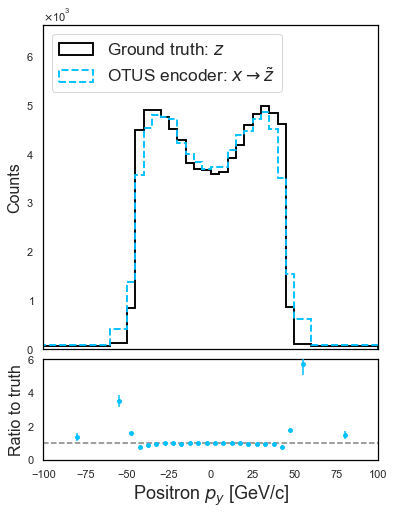

In [21]:
#-- Plot this for the positron's py --#
ratioPlotSingle(z_test2[:,5], z_pred_te1[:,5], zbinsList[0], (-100,100), (0,7000), (0., 6.05), 
                   r'Positron $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir) #zStatsList[0],

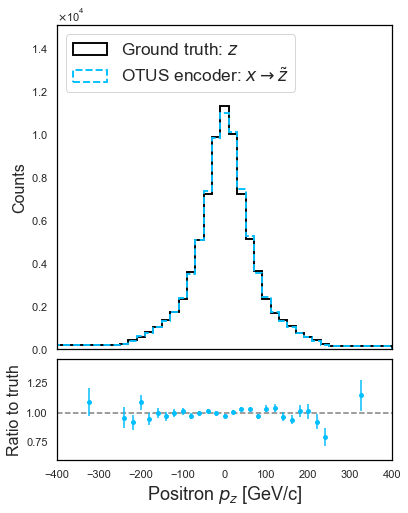

In [22]:
#-- Plot this for the positron's pz --#
ratioPlotSingle(z_test2[:,6], z_pred_te1[:,6], zbinsList[1], (-400,400), (0,7000), (.6,1.45), 
                   r'Positron $p_z$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir) #zStatsList[1], 


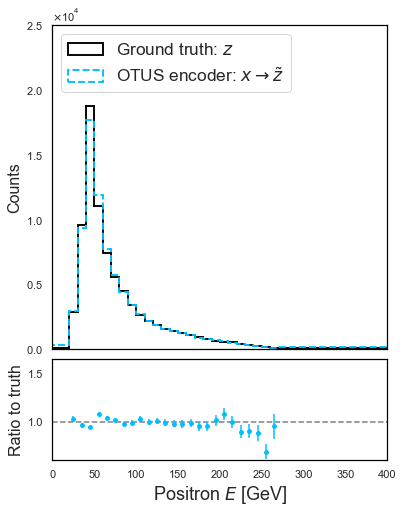

In [23]:
#-- Plot this for the positron's E --#
ratioPlotSingle(z_test2[:,7], z_pred_te1[:,7], zbinsList[2], (0,400), (0,7000), (.6,1.65), 
                   r'Positron $E$ [GeV]', legend=True, save_figs=save_figs, img_dir=img_dir) #zStatsList[2], 

## Create Principal Axes Plots x-space

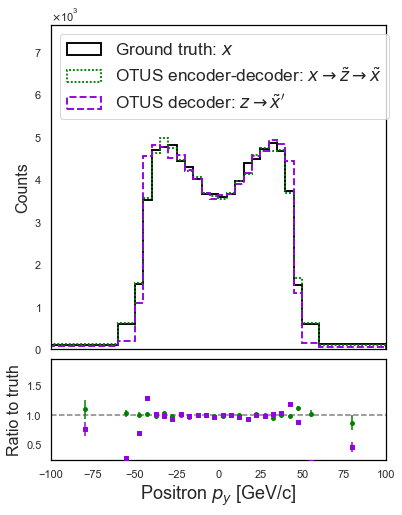

In [24]:
#-- Plot this for the positron's py --#
ratioPlotDouble(x_test2[:,5], x_pred_te1[:,5], x_pred_truth_te1[:,5], xbinsList[0], 
                   (-100,100), (0,7000), (.25,1.95), 
                   r'Positron $p_y$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir)

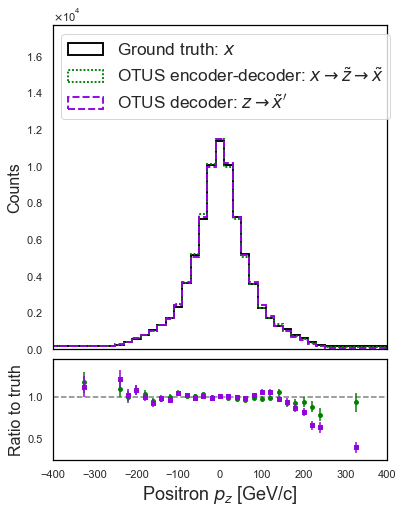

In [25]:
#-- Plot this for the positron's pz --#
ratioPlotDouble(x_test2[:,6], x_pred_te1[:,6], x_pred_truth_te1[:,6], xbinsList[1], 
                   (-400,400), (0,7000), (0.25,1.45), 
                   r'Positron $p_z$ [GeV/c]', legend=True, save_figs=save_figs, img_dir=img_dir) #xStatsList[1], xStatsListTruth[1],

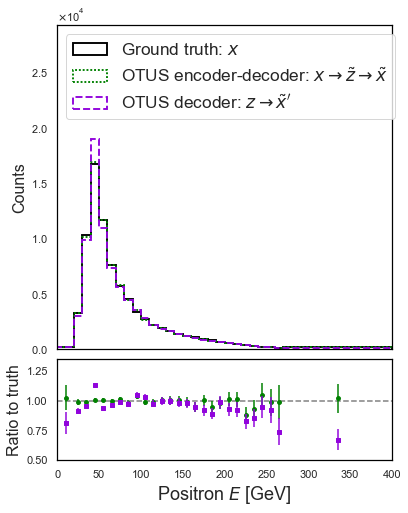

In [26]:
#-- Plot this for the positron's E --#
ratioPlotDouble(x_test2[:,7], x_pred_te1[:,7], x_pred_truth_te1[:,7], xbinsList[2], 
                   (0,400), (0,7000), (.5,1.35), 
                   r'Positron $E$ [GeV]', legend=True, save_figs=save_figs, img_dir=img_dir) #xStatsList[2], xStatsListTruth[2], 

# Calculate Invariant Mass of Z Boson

In [27]:
from func_utils import calcInvM

In [28]:
#-- Calculate Invariant Mass of Z boson --#

# z-space (z_pred_te1 vs z_test2)
zpred_IM_Z = calcInvM(z_pred_te1[:,0:4] + z_pred_te1[:,4:8])
ztest_IM_Z = calcInvM(z_test2[:,0:4] + z_test2[:,4:8])

# x-space
xpred_IM_Z      = calcInvM(x_pred_te1[:,0:4] + x_pred_te1[:,4:8])
xtest_IM_Z      = calcInvM(x_test2[:,0:4] + x_test2[:,4:8])
xpredtruth_IM_Z = calcInvM(x_pred_truth_te1[:,0:4] + x_pred_truth_te1[:,4:8])

## Perform Statistical Analysis

### z-space Find Correct Binning and Compute Statistics

In [29]:
bins = [70 + 1*i for i in range(40+1)]

n, _, _ = plt.hist(zpred_IM_Z, bins=bins, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [ 313.  351.  380.  431.  458.  543.  704.  742.  950. 1071. 1296. 1517.
 1808. 2161. 2493. 2913. 3603. 4118. 4645. 4924. 4991. 4874. 4574. 4008.
 3512. 2871. 2465. 2046. 1680. 1428. 1221. 1004.  930.  718.  664.  575.
  478.  439.  356.  312.]
Do any bins have less than 5 entries?  False


In [30]:
zIMstatsList = []

bins_Z = bins

zIMstatsList.append(runStatAnalysis(zpred_IM_Z, ztest_IM_Z, bins_Z))

### x-space Find Correct Binning and Compute Statistics

In [31]:
# Want to find bins such that n has no bins with <5 entries
# Try using binning for z-space case
bins = bins_Z
n, _, _ = plt.hist(xpred_IM_Z, bins=bins, histtype='step', density=False)
print("Number of entries in each bin: ",n)
print("Do any bins have less than 5 entries? ",np.any(n < 5))

plt.close() # Don't show plot

Number of entries in each bin:  [  86.  102.  119.  152.  153.  192.  219.  253.  293.  369.  425.  574.
  757. 1033. 1436. 2104. 3142. 4620. 6743. 8694. 9978. 9755. 8129. 6009.
 4113. 2539. 1507. 1095.  696.  500.  370.  308.  240.  175.  156.  155.
  120.   97.   87.   81.]
Do any bins have less than 5 entries?  False


In [32]:
xIMstatsList = []
xIMstatsListTruth = []

xIMstatsList.append(runStatAnalysis(xpred_IM_Z, xtest_IM_Z, bins_Z))
xIMstatsListTruth.append(runStatAnalysis(xpredtruth_IM_Z, xtest_IM_Z, bins_Z))

## Plot z-space Invariant mass

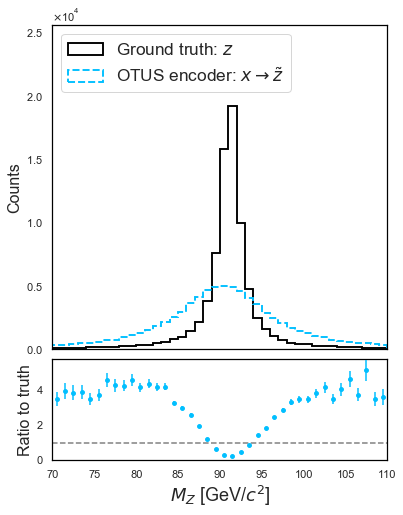

In [33]:
ratioPlotSingle(ztest_IM_Z, zpred_IM_Z, bins_Z, (70,110), (0,60000), (0,5.75), 
                   r'$M_{Z}$ [GeV/$c^2$]', legend=True, save_figs=save_figs, img_dir=img_dir) #zIMstatsList[0], 

## Plot x-space Invariant mass

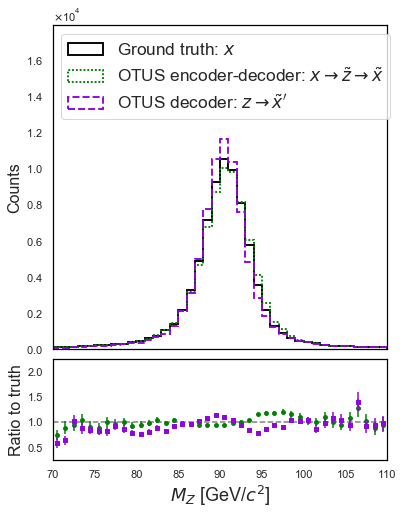

In [34]:
ratioPlotDouble(xtest_IM_Z, xpred_IM_Z, xpredtruth_IM_Z, bins_Z, 
                   (70,110), (0,12000), (0.25,2.25),  
                   r'$M_{Z}$ [GeV/$c^2$]', legend=True, save_figs=save_figs, img_dir=img_dir) #xIMstatsList[0],  xIMstatsListTruth[0], 

# Create Transport Plots

## Decoder $\tilde{z} \rightarrow \tilde{x}$

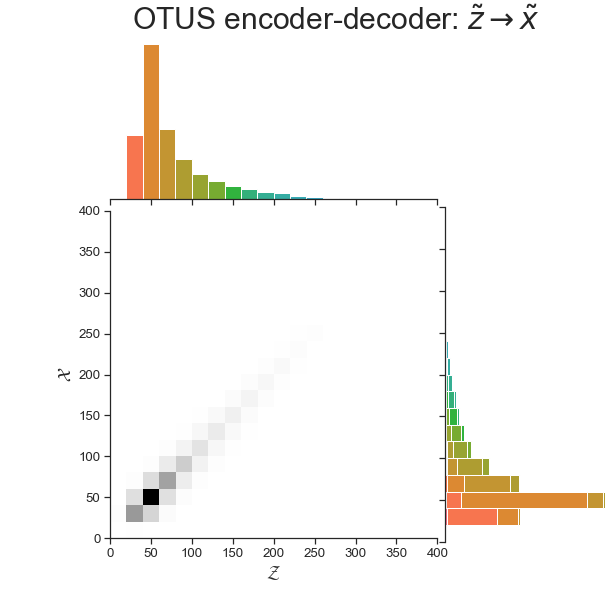

In [35]:
#-- Make decoder transport plot from learned latent space--#

# Positron energy
Z = z_pred_te1[:,7].reshape(-1,1)
X = x_pred_te1[:,7].reshape(-1,1)

n = Z.shape[1]
ZX = [np.concatenate((Z[:,i].reshape(-1,1), X[:,i].reshape(-1,1)), axis=1) for i in range(n)]

transportPlot(ZX[0], zlim=(0,400), xlim=(0,400), nz=20, nx=20, name='decTransport_zpred_xpred_te.png', dec=True, title=r'$\hspace{4}$ OTUS encoder-decoder: $\tilde{z} \rightarrow \tilde{x}$', save_figs=save_figs, img_dir=img_dir)

## Delphes $z \rightarrow x$

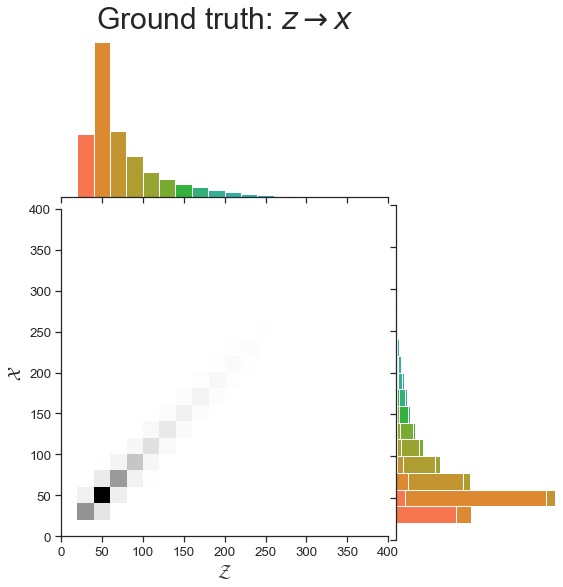

In [36]:
#-- Make delphes transport plot --#

# Electron energy
Z = z_test1[:,7].reshape(-1,1)
X = x_test1[:,7].reshape(-1,1)

n = Z.shape[1]
ZX = [np.concatenate((Z[:,i].reshape(-1,1), X[:,i].reshape(-1,1)), axis=1) for i in range(n)]

transportPlot(ZX[0], zlim=(0,400), xlim=(0,400), nz=20, nx=20, name='delphesTransport_ztest_xtest.png', dec=True, title=r'Ground truth: $z \rightarrow x$', save_figs=save_figs, img_dir=img_dir)

## Decoder $z \rightarrow \tilde{x}^\prime$

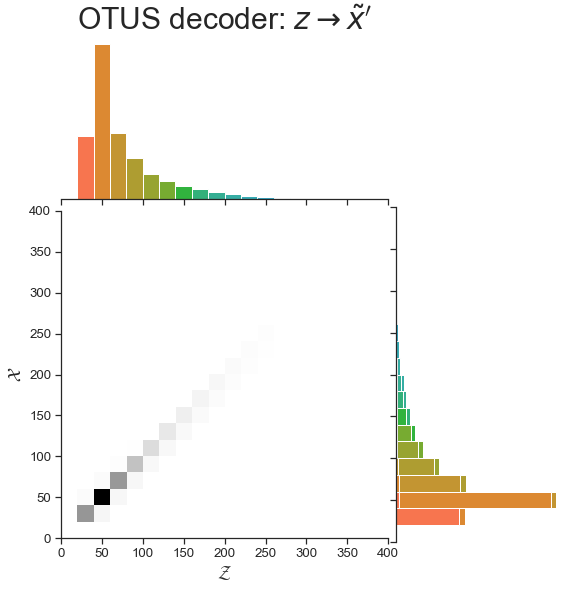

In [37]:
#-- Make decoder transport plot from truth --#

# Electron energy
Z = z_test1[:,7].reshape(-1,1)
X = x_pred_truth_te1[:,7].reshape(-1,1)

n = Z.shape[1]
ZX = [np.concatenate((Z[:,i].reshape(-1,1), X[:,i].reshape(-1,1)), axis=1) for i in range(n)]

transportPlot(ZX[0], zlim=(0,400), xlim=(0,400), nz=20, nx=20, name='decTransport_ztruth_xpredtruth_te.png', dec=True, title=r'OTUS decoder: $z \rightarrow \tilde{x}^\prime$', save_figs=save_figs, img_dir=img_dir)

# Statistics Tables

We document the results of the above statistical tests in LaTeX table friendly format.

In [38]:
from func_utils import statTableSingle, statTableDouble

## Supplementary Table 1 (z-space)

In [39]:
# Fig. 2a: fracDiff_zpred_z_Positronp_y.png
statTableSingle(statList12=zStatsList[0], figLabel='2a', cline=True)

# Fig. 2b: fracDiff_zpred_z_Positronp_z.png
statTableSingle(statList12=zStatsList[1], figLabel='2b', cline=True)

# Fig. 2c: fracDiff_zpred_z_PositronE.png
statTableSingle(statList12=zStatsList[2], figLabel='2c', cline=False)

# Fig. 4a: fracDiff_zpred_z_M_Z.png
statTableSingle(statList12=zIMstatsList[0], figLabel='4a', cline=False)

\footnotesize{\textbf{Fig. 2a}} & \footnotesize{$1.34 \times 10^{+00}$} & \footnotesize{($50.583$, $23$)} & \footnotesize{$1.61 \times 10^{-02}$}\\\cline{2-4}
\footnotesize{\textbf{Fig. 2b}} & \footnotesize{$1.59 \times 10^{+00}$} & \footnotesize{($1.325$, $26$)} & \footnotesize{$4.90 \times 10^{-03}$}\\\cline{2-4}
\footnotesize{\textbf{Fig. 2c}} & \footnotesize{$1.29 \times 10^{+00}$} & \footnotesize{($8.814$, $26$)} & \footnotesize{$1.47 \times 10^{-02}$}\\\hline
\footnotesize{\textbf{Fig. 4a}} & \footnotesize{$2.73 \times 10^{+01}$} & \footnotesize{($822.762$, $39$)} & \footnotesize{$2.46 \times 10^{-01}$}\\\hline


## Supplementary Table 2 (x-space)

In [40]:
# Fig. 2d: fracDiff_xpred_xpredtruth_x_Positronp_y.png
statTableDouble(statList12=xStatsList[0], statList13=xStatsListTruth[0], figLabel='2d', cline=True)

# Fig. 2e: fracDiff_xpred_xpredtruth_x_Positronp_z.png
statTableDouble(statList12=xStatsList[1], statList13=xStatsListTruth[1], figLabel='2e', cline=True)

# Fig. 2f: fracDiff_xpred_xpredtruth_x_PositronE.png
statTableDouble(statList12=xStatsList[2], statList13=xStatsListTruth[2], figLabel='2f', cline=False)

# Fig. 4b: fracDiff_xpred_xpredtruth_x_M_Z.png
statTableDouble(statList12=xIMstatsList[0], statList13=xIMstatsListTruth[0], figLabel='4b', cline=False)

\footnotesize{\textbf{Fig. 2d}} & \footnotesize{$4.22 \times 10^{-01}$} & \footnotesize{($1.391$, $23$)} & \footnotesize{$3.48 \times 10^{-03}$} & \footnotesize{$1.05 \times 10^{+00}$} & \footnotesize{($37.560$, $23$)} & \footnotesize{$1.22 \times 10^{-02}$}\\\cline{2-7}
\footnotesize{\textbf{Fig. 2e}} & \footnotesize{$3.71 \times 10^{+00}$} & \footnotesize{($1.523$, $26$)} & \footnotesize{$1.03 \times 10^{-02}$} & \footnotesize{$9.53 \times 10^{+00}$} & \footnotesize{($4.775$, $26$)} & \footnotesize{$7.49 \times 10^{-03}$}\\\cline{2-7}
\footnotesize{\textbf{Fig. 2f}} & \footnotesize{$6.64 \times 10^{-01}$} & \footnotesize{($0.489$, $26$)} & \footnotesize{$3.19 \times 10^{-03}$} & \footnotesize{$3.64 \times 10^{+00}$} & \footnotesize{($9.370$, $26$)} & \footnotesize{$2.00 \times 10^{-02}$}\\\hline
\footnotesize{\textbf{Fig. 4b}} & \footnotesize{$7.28 \times 10^{-01}$} & \footnotesize{($5.055$, $39$)} & \footnotesize{$2.61 \times 10^{-02}$} & \footnotesize{$7.15 \times 10^{-01}$} & \foo